In [34]:
# prediction.py - Enhanced PICT Parking Prediction System

# -------------------------------
# Imports and Setup
# -------------------------------
import json
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
import googlemaps
import aiohttp
import asyncio
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Constants
BACKEND_API_BASE = "http://localhost:3000/api"

app = FastAPI(title="PICT Parking Prediction System", version="1.0.0")

# Google Maps client
try:
    gmaps = googlemaps.Client(key=os.getenv('GOOGLE_MAPS_API_KEY'))
except:
    gmaps = None
    print("Warning: Google Maps API key not found")

# PICT College coordinates and parking areas
PICT_LOCATION = {
    "lat": 18.5204,
    "lng": 73.8567,
    "address": "PICT College, Pune, Maharashtra"
}


In [56]:
# Major parking destinations in Pune area
PARKING_AREAS = {
    "pict_campus": {
        "lat": 18.5204, 
        "lng": 73.8567, 
        "total_slots": 500, 
        "name": "PICT Campus Parking",
        "hourly_rate": 20,
        "area": "Kharadi"
    },
    "amanora_mall": {
        "lat": 18.5314, 
        "lng": 73.8982, 
        "total_slots": 800, 
        "name": "Amanora Mall Parking",
        "hourly_rate": 30,
        "area": "Hadapsar"
    },
    "seasons_mall": {
        "lat": 18.5078, 
        "lng": 73.9200, 
        "total_slots": 600, 
        "name": "Seasons Mall Parking",
        "hourly_rate": 25,
        "area": "Magarpatta"
    },
    "kharadi_it_park": {
        "lat": 18.5110, 
        "lng": 73.8567, 
        "total_slots": 400, 
        "name": "Kharadi IT Park Parking",
        "hourly_rate": 35,
        "area": "Kharadi"
    },
    "eon_it_park": {
        "lat": 18.5089, 
        "lng": 73.8612, 
        "total_slots": 350, 
        "name": "EON IT Park Parking",
        "hourly_rate": 40,
        "area": "Kharadi"
    }
}

import os
import json
import pickle
import xgboost as xgb

MODEL_PATH = "xgb_parking_dynamic.json"      # trained regressor
FEATURE_PATH = "dynamic_features.json"
ENCODER_PATH = "categorical_encoders.pkl"

# -------------------------------
# Load trained model safely
# -------------------------------
try:
    xgb_model = xgb.XGBRegressor()  # REGRESSOR
    if os.path.exists(MODEL_PATH):
        xgb_model.load_model(MODEL_PATH)
        print("✅ XGBoost model loaded successfully.")
    else:
        xgb_model = None
        print("⚠️ Warning: Model not found!")

    # Load feature order
    if os.path.exists(FEATURE_PATH):
        with open(FEATURE_PATH, "r") as f:
            feature_order = json.load(f)
        print("✅ Feature order loaded.")
    else:
        print("⚠️ Feature file not found. Using fallback order.")
        feature_order = [
            "city", "area", "parking_lot_name", "day_of_week", "time_of_day",
            "is_weekend", "is_holiday", "weather_condition", "temperature_c",
            "traffic_density", "distance_from_user_km", "vehicle_type",
            "base_price", "dynamic_multiplier", "final_price", "event_nearby",
            "total_slots", "occupied_slots", "free_slots",
            "slots_free_in_15min", "future_bookings_15min"
        ]

    # Load encoders (for categorical columns)
    if os.path.exists(ENCODER_PATH):
        with open(ENCODER_PATH, "rb") as f:
            encoders = pickle.load(f)
        print("✅ Encoders loaded.")
    else:
        encoders = None
        print("⚠️ Warning: Encoders not found. Will skip categorical encoding.")

except Exception as e:
    print(f"❌ Error loading model components: {e}")
    xgb_model, encoders, feature_order = None, None, []


✅ XGBoost model loaded successfully.
✅ Feature order loaded.
✅ Encoders loaded.


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

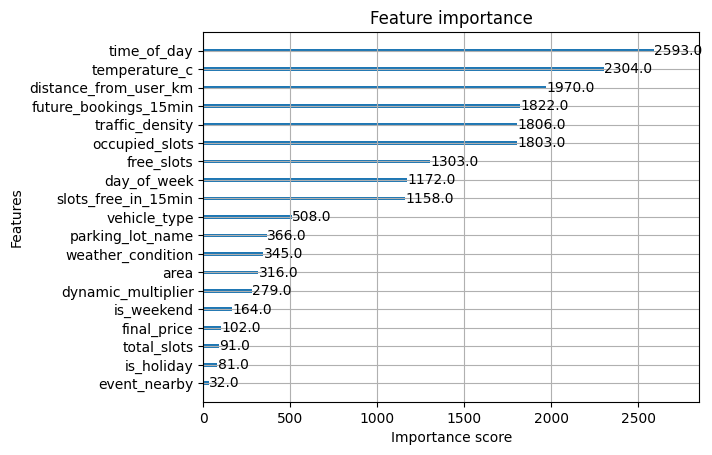

In [37]:
xgb.plot_importance(xgb_model)

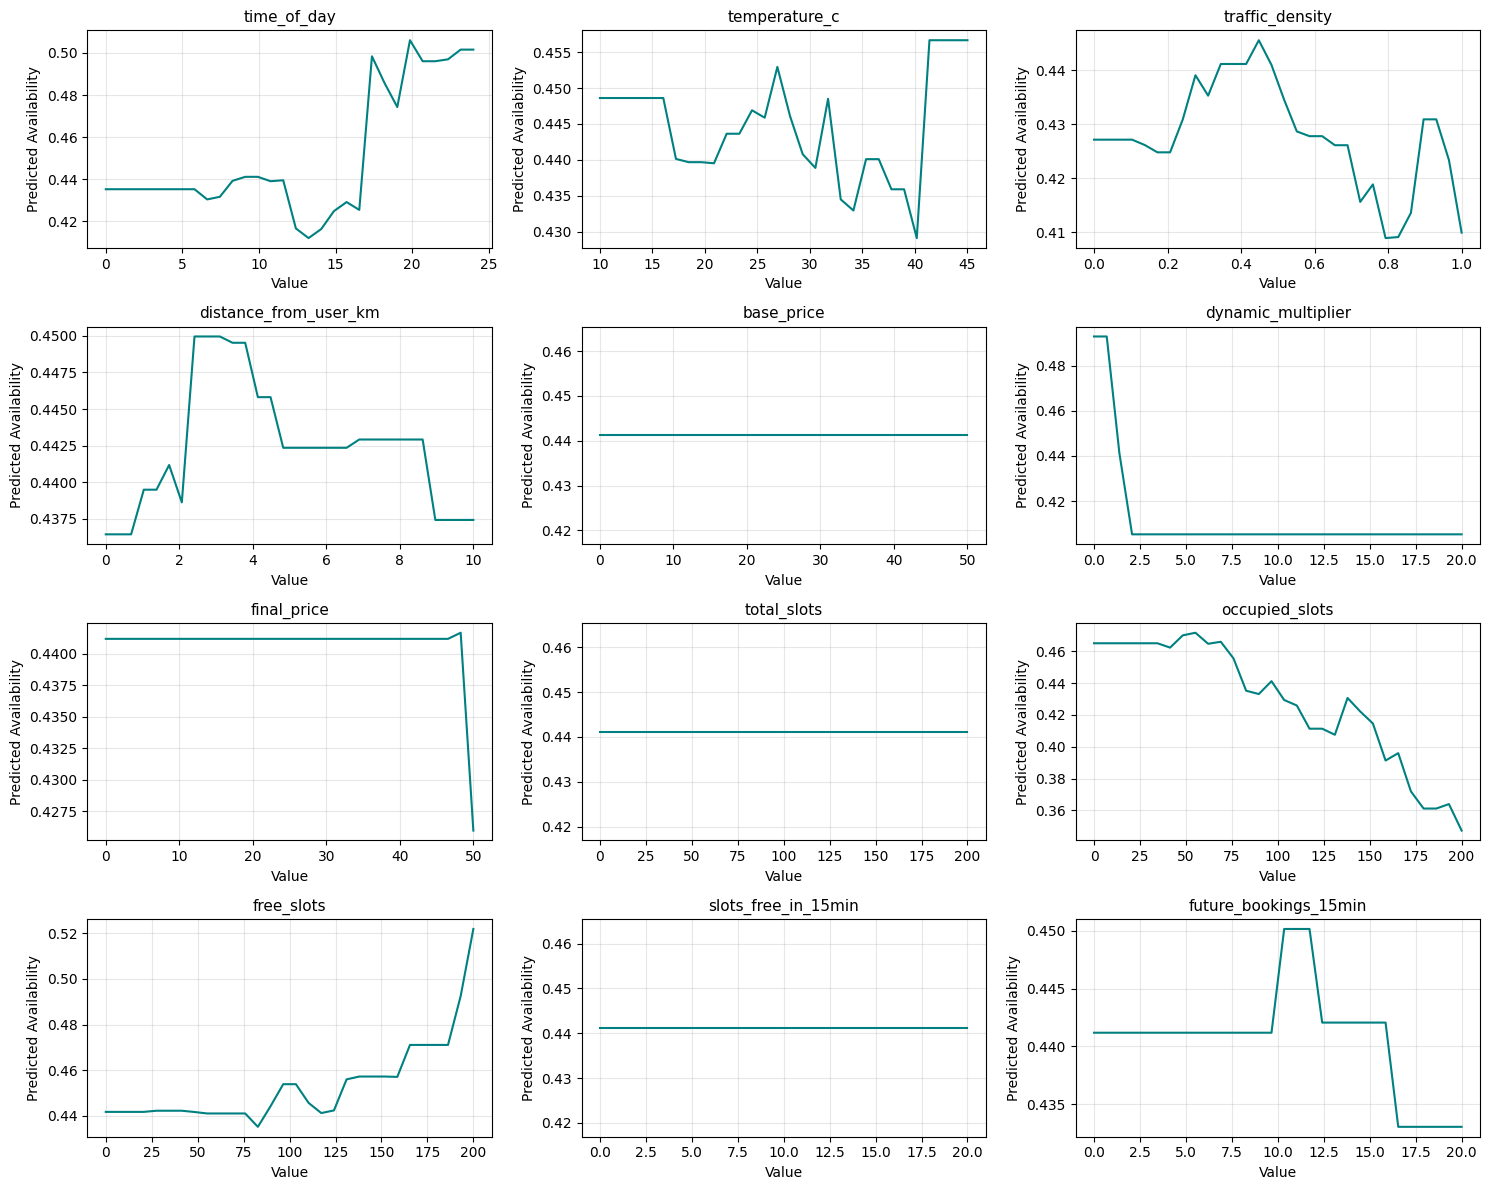

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Define base sample
base_sample = {
    "city": "Pune",
    "area": "Dhankawadi",
    "parking_lot_name": "PICT Main Parking",
    "day_of_week": "Monday",
    "time_of_day": 10.0,
    "is_weekend": 0,
    "is_holiday": 0,
    "weather_condition": "Clear",
    "temperature_c": 30.0,
    "traffic_density": 0.4,
    "distance_from_user_km": 2.0,
    "vehicle_type": "car",
    "base_price": 20.0,
    "dynamic_multiplier": 1.2,
    "final_price": 24.0,
    "event_nearby": 0,
    "total_slots": 150,
    "occupied_slots": 100,
    "free_slots": 50,
    "slots_free_in_15min": 45,
    "future_bookings_15min": 2
}

# Helper: Encode categorical features if encoders exist
def encode_input(df: pd.DataFrame) -> pd.DataFrame:
    if encoders:
        for col, encoder in encoders.items():
            if col in df.columns:
                try:
                    df[col] = encoder.transform(df[col])
                except:
                    df[col] = encoder.transform([encoder.classes_[0]])[0]
    return df

# Identify numeric features
# Define numeric features to visualize
numeric_features = [
    "time_of_day", "temperature_c", "traffic_density",
    "distance_from_user_km", "base_price", "dynamic_multiplier",
    "final_price", "total_slots", "occupied_slots",
    "free_slots", "slots_free_in_15min", "future_bookings_15min"
]

# Base DataFrame
base_df = pd.DataFrame([base_sample])

# Helper to compute predictions for one feature
def get_feature_effect(feature_name, start, end, steps=30):
    values = np.linspace(start, end, steps)
    preds = []
    for v in values:
        temp_df = base_df.copy()
        temp_df[feature_name] = v
        temp_df_encoded = encode_input(temp_df)
        temp_df_encoded = temp_df_encoded[feature_order]
        preds.append(xgb_model.predict(temp_df_encoded)[0])
    return values, preds


# Create a multi-plot grid
n_features = len(numeric_features)
cols = 3
rows = math.ceil(n_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    # Define plot ranges for each feature
    if feature == "traffic_density":
        start, end = 0, 1
    elif feature == "temperature_c":
        start, end = 10, 45
    elif feature == "time_of_day":
        start, end = 0, 24
    elif feature in ["base_price", "final_price"]:
        start, end = 0, 50
    elif feature == "distance_from_user_km":
        start, end = 0, 10
    elif feature in ["total_slots", "occupied_slots", "free_slots"]:
        start, end = 0, 200
    else:
        start, end = 0, 20
    
    x_vals, y_vals = get_feature_effect(feature, start, end)
    ax.plot(x_vals, y_vals, color='teal')
    ax.set_title(feature, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Value")
    ax.set_ylabel("Predicted Availability")

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

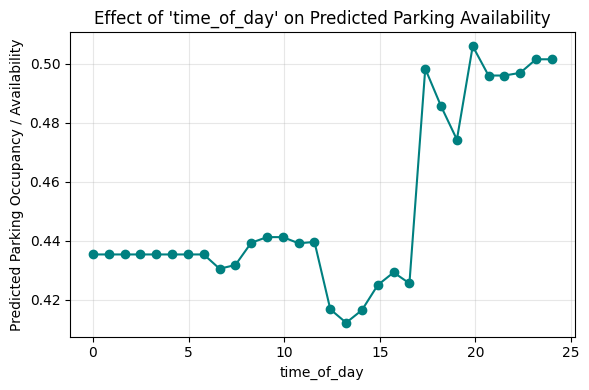

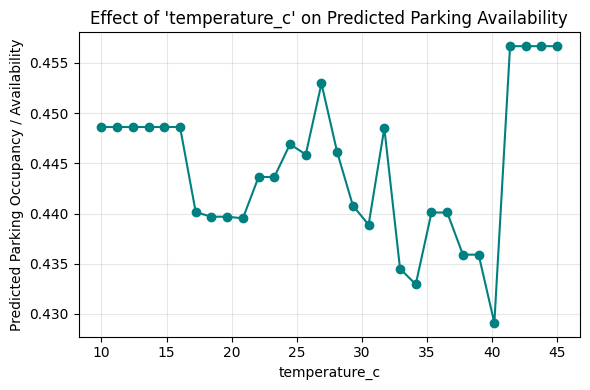

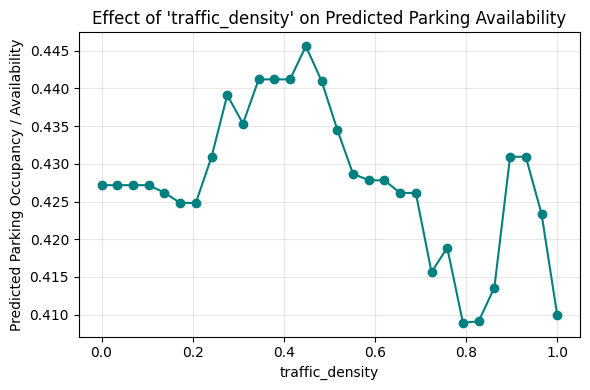

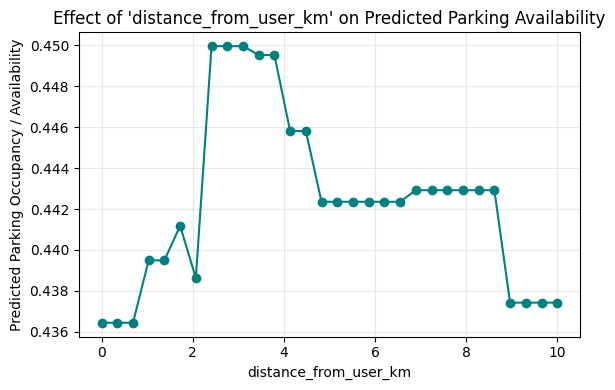

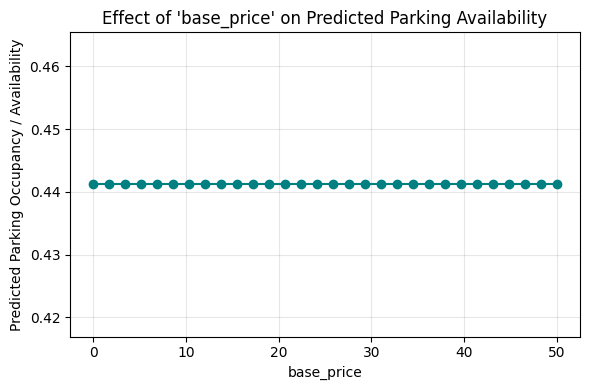

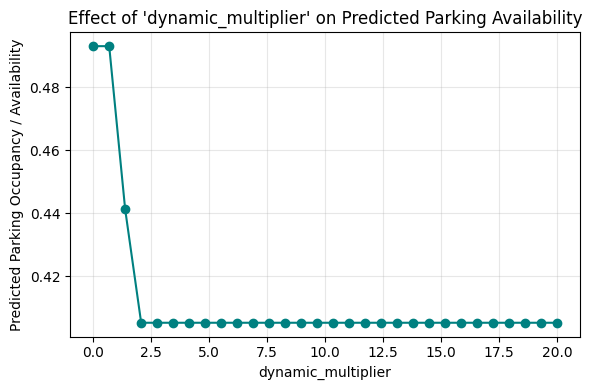

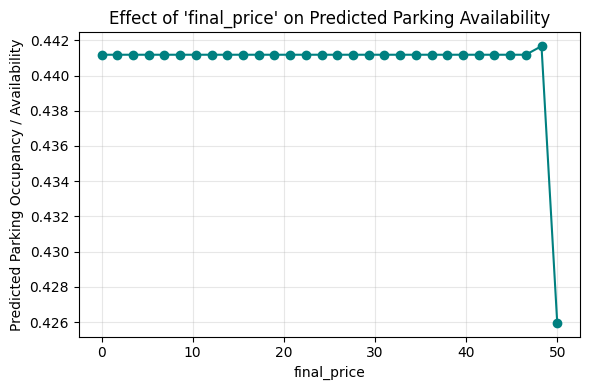

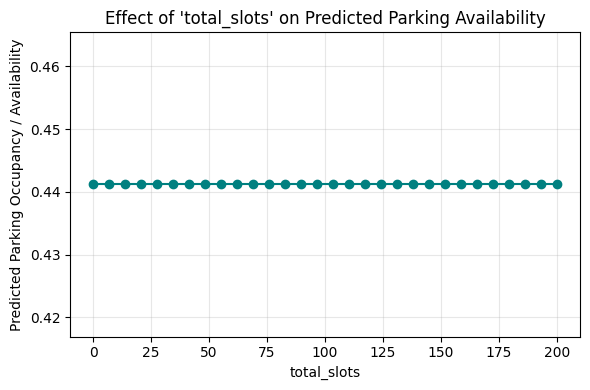

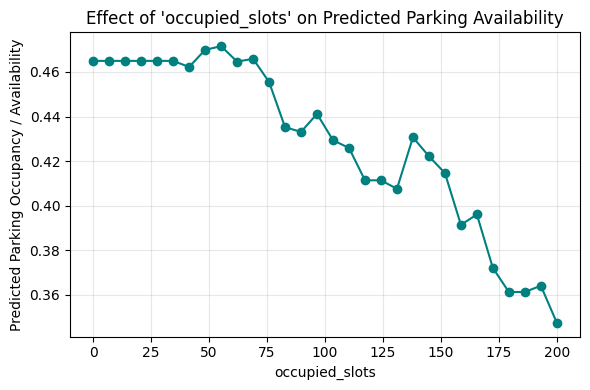

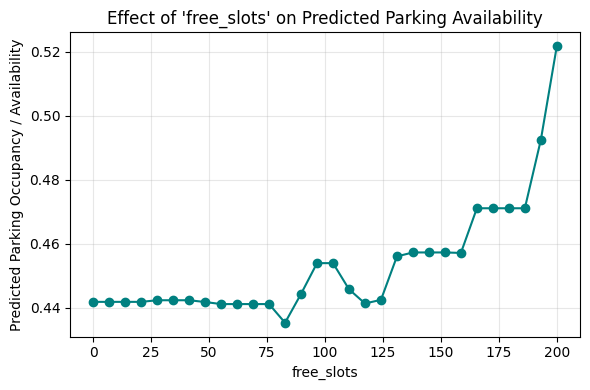

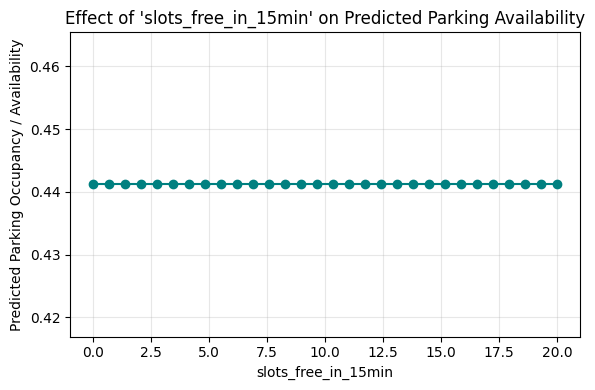

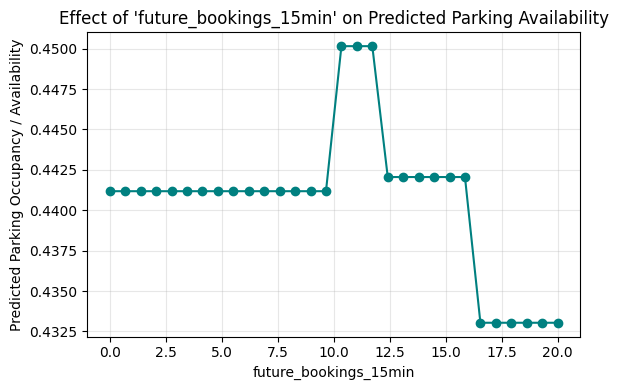

In [59]:
for feature in numeric_features:
    if feature == "traffic_density":
        plot_feature_effect(feature, 0, 1)
    elif feature == "temperature_c":
        plot_feature_effect(feature, 10, 45)
    elif feature == "time_of_day":
        plot_feature_effect(feature, 0, 24)
    elif feature in ["base_price", "final_price"]:
        plot_feature_effect(feature, 0, 50)
    elif feature == "distance_from_user_km":
        plot_feature_effect(feature, 0, 10)
    elif feature in ["total_slots", "occupied_slots", "free_slots"]:
        plot_feature_effect(feature, 0, 200)
    else:
        plot_feature_effect(feature, 0, 20)
